## Question1: Does clinical trial numbers, clinical treatment,  and phrases impact the stock performance?


### Getting the Drug Name for Each Clinical Trial:

In [11]:
#%run merge_code.ipynb

In [2]:
def change_placebo(dataframe):
    import re
    if dataframe['treatment']=="Placebo":
        dataframe['treatment']=dataframe['interventions'].split(':')[-1]
    else:
        dataframe['treatment']=dataframe['treatment']
    return dataframe


def change_specific_treatments(row):
    if row =='':
        return 'FP-R01-MG-F2'
    elif row=='0.9':
        return 'AZD1222'
    elif row=='1':
        return 'CoV2SAM(LNP)'
    elif row=='100':
        return 'Virazole'
    elif row=='50': 
        return 'Virazole'
    elif row=='BGB': 
        return 'BGB-DXP593'
    elif row=='COVID-19': 
        return 'Spike-GM-CSF'
    elif row=='Cliniporator': 
        return 'CORVax'
    elif row=='Group': 
        return 'HCQ'
    elif row=='High': 
        return 'Radiation'
    elif row=='ISIS': 
        return 'ISIS-721744'
    elif row=='Interferon': 
        return 'Remdesivir'
    elif row=='Longeveron': 
        return 'LMSC'
    elif row=='Marker': 
        return 'D2000'
    elif row=='Nitric': 
        return 'iNO'
    elif row=='No': 
        return 'None'
    elif row=='Part': 
        return 'Upamostat'
    elif row=='Pegylated': 
        return 'Peginterferon'
    elif row=='Placebos': 
        return 'Azithromycin'
    elif row=='Recombinant': 
        return 'Rintatolimod'
    elif row=='Routine': 
        return 'None'
    elif row=='Saline': 
        return 'Ampion'
    elif row=='Self': 
        return 'KB109'
    elif row=='Sodium': 
        return 'SAM-LNP'
    elif row=='To': 
        return 'Ad26.COV2.S'
    elif row=='Trans': 
        return 'TSC'
    elif row=='draw': 
        return 'blood'
    elif row=='RDV':
        return 'remdesivir'
    elif row=='Remdesivir (RDV)':
        return 'remdesivir'
    elif row=='REGN10933 + REGN10987':
        return 'REGN10933/REGN10987'
    elif row=='REGN10933+REGN10987 combination therapy':
        return 'REGN10933/REGN10987'    
    else:
        return row

    
def change_selected_cells(dataframe, index_newcell, column):
    '''With the zip lists, change the find selected index and selected column, to the desired new values'''
    for index, v in index_newcell.items():
        dataframe.loc[index, column]=v
    return dataframe


q1=df.copy()

#Getting treatment names from intervention
q1['treatment']=q1['intervention_details'].str.extract(r'^[\w]*:([\w\-\.]*)')

#Some names of the drugs were not extracted properly
q1['treatment']=q1.treatment.apply(change_specific_treatments)
q1=q1.apply(change_placebo, axis=1)
q1['treatment']=q1['treatment'].str.strip(' ')

change_treatment_index=[39, 82, 163, 165, 295, 304]
change_treatments=['otilimab','remdesivir','ampion','SOC','gammaCore','sirukumab']
change_index_treatments=dict(zip(change_treatment_index, change_treatments))
q1=q1.reset_index()
q1=change_selected_cells(q1,  change_index_treatments, 'treatment')

### Get Nature of the Treatment:

In [3]:
def detail_treatments_func(df):
    """Extracting the type of treatment based on the name"""
#other biologics: enzymes, antibotic, steroids, heparin
#biologics: antiviral, antibodies

    #anything with 'mab' is antibody
    import re
    if re.match(r'.+mab$', str(df['treatment']).lower()):
        df['detail_treatment']='antibody'
        
    ###find all the vaccines
    elif re.match(r'vaccine', str(df['keywords']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'vaccine', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+cine', str(df['intervention_details']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+vac', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
    elif re.match(r'.+vax', str(df['treatment']).lower()):
        df['detail_treatment']='vaccine'
                                   
    #antiviral
    elif re.match(r'.+vir$', str(df['treatment']).lower()):
        df['detail_treatment']='antiviral'
                                   
    #small molecule drugs
    elif re.match(r'.+oral.+', str(df['intervention_details']).lower()):
        df['detail_treatment']='small molecule drugs'                                   
    elif re.match(r' po ', str(df['intervention_details']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'.+nib$', str(df['treatment']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'.olone$', str(df['treatment']).lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'\w+\-\d+', str(df['treatment']).strip(' ').lower()):
        df['detail_treatment']='small molecule drugs'
    elif re.match(r'\w+\d+', str(df['treatment']).strip(' ').lower()):
        df['detail_treatment']='small molecule drugs'
    else:
        df['detail_treatment']='other treatments'
    return df

q1['detail_treatment']=None
q1=q1.apply(detail_treatments_func, axis=1)

### Change Clinical Trial Phases to Numberical:

In [4]:
columns=['nct_id', 'status', 'study_type', 'phases','keywords', 'interventions', 'intervention_details','start_date',
         'primary_completion_date', 'completion_date','results_first_posted', 'is_fda_regulated_drug', 
         'is_fda_regulated_device','is_unapproved_device', 'locations', 'Country','merge_name','Stock_Symbol', 'Stock_Name', 'treatment',
       'detail_treatment']
active_status=['Active, not recruiting', 'Completed', 'Not yet recruiting','No longer available', 'Recruiting', 'Available',
               'Approved for marketing', 'Enrolling by invitation']


def phases_function(row):
    if (row=='Phase 1') | (row=='Early Phase 1'):
        return 1
    elif row=='Phase 1|Phase 2':
        return 1.5
    elif row=='Phase 2':
        return 2
    elif row=='Phase 2|Phase 3':
        return 2.5
    elif row=='Phase 3':
        return 3
    elif row=='Phase 4':
        return 4
    
    
def completed_trials(df):
    '''if drugs is ready to market, then it's 1 or else it's 0'''
    if (df['phases_no']==3) & (df['status']=='Completed'):
        df['market_drug']=1
    else: 
        df['market_drug']=0
    return df


#only want the active/ already in market clinical trials:
q1=q1[q1.status.isin(active_status)][columns]


#discard all the phases without phases and get phases of each drug
q1=q1[~q1.phases.isna()]
q1['phases_no']=q1['phases'].map(phases_function)
q1=q1.apply(completed_trials, axis=1)

### Does the number of Clinical Trials impact the stocks?

In [5]:
def change_in_price(df):
    try:
        prices=pdr.get_data_yahoo(df['Stock_Symbol'], start=df['2wks_before'], end=df['2wks_after'])
        prices['daily_average']=(prices['High']+prices['Low'])/2
        value=((prices.iloc[-1]['daily_average']-prices.iloc[0]['daily_average'])/prices.iloc[0]['daily_average'])*100
        df['percentage']=value
    except:
        df['percentage']=None
    return df

#interested in stock prices two weeks before the clinical trial started and two weeks after clinical started
q1_num=q1.groupby('Stock_Symbol').agg({'treatment': len, 'start_date':(min, max)}).reset_index().droplevel(0, axis=1)
q1_num=q1_num.rename(columns={'':'Stock_Symbol','min':'start_date_min', 'max':'start_date_max'})

q1_num['2wks_before']=q1_num.start_date_min-DateOffset(weeks=2)
q1_num['2wks_after']=q1_num.start_date_max+DateOffset(weeks=2)

#use Yahoo Finance to get change stock price from two weeks before 'start_date' and two weeks after "start_date"
q1_num_price=q1_num.apply(change_in_price, axis=1)
q1_num_price

,Stock_Symbol,len,start_date_min,start_date_max,2wks_before,2wks_after,percentage
0,ABBV,4,2020-03-18,2020-12-10,2020-03-04,2020-12-24,13.926221
1,ABIO,1,2020-12-10,2020-12-10,2020-11-26,2020-12-24,-0.462963
2,ADMP,1,2021-05-01,2021-05-01,2021-04-17,2021-05-15,-1.418443
3,AIM,1,2020-09-04,2020-09-04,2020-08-21,2020-09-18,-15.734990
4,ALT,2,2020-10-10,2021-02-28,2020-09-26,2021-03-14,37.325898
...,...,...,...,...,...,...,...
93,VRNA,1,2020-09-04,2020-09-04,2020-08-21,2020-09-18,-15.044248
94,VSTM,2,2020-10-12,2020-11-18,2020-09-28,2020-12-02,61.176479
95,VTGN,1,2020-11-30,2020-11-30,2020-11-16,2020-12-14,2.068968
96,VXRT,1,2020-09-21,2020-09-21,2020-09-07,2020-10-05,30.057253


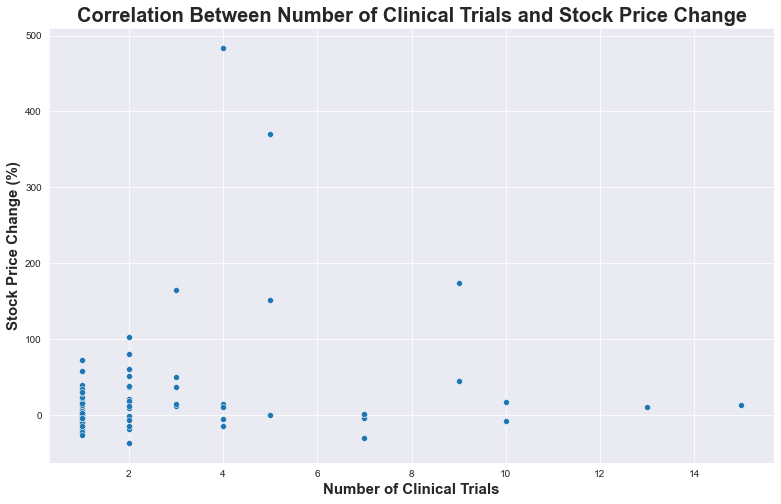

In [6]:
def plot_single(data, x, y, x_name, y_name, title): 
    plt.figure(figsize=(13,8))
    sns.color_palette("Set2")
    sns.set_style('darkgrid')
    sns.scatterplot(x = 'len', y = 'percentage', data = q1_num_price,)
    
    plt.xlabel(x_name, fontdict={'fontsize': 15, 'weight':'bold'})
    plt.ylabel(y_name, fontdict={'fontsize': 15, 'weight':'bold'})
    plt.title(title, fontdict={'fontsize': 20, 'weight':'bold'})

    
plot_single(q1_num_price, "len", 'percentage', 'Number of Clinical Trials', 'Stock Price Change (%)', \
            "Correlation Between Number of Clinical Trials and Stock Price Change")

### Figure1.1 The Number of Clinical Trials vs Price Change of Stocks:

Here we explore the whether the company with more COVID-19 clinical trials will have a bigger price change in their stock price. Our result that companies with more clinical trials did not correlate with a higher stock change. 

### Does the type of treatment impact the stock price change?

In [7]:
#copy from the cleaned version of q1
q1_phase=q1.copy()
q1_phase['2wks_before']=q1_phase.start_date-DateOffset(weeks=2)
q1_phase['2wks_after']=q1_phase.start_date+DateOffset(weeks=2)

q1_phase_price=q1_phase.apply(change_in_price, axis=1)


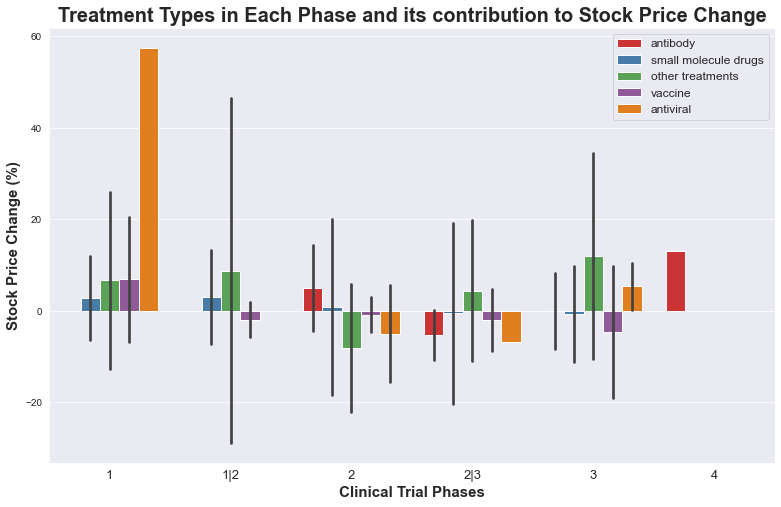

In [8]:
#plot the graph
fig, ax=plt.subplots(1, figsize=(13,8))
sns.color_palette('Set1')
sns.set_style('darkgrid')

sns.barplot(x="phases_no", y="percentage", hue='detail_treatment', data=q1_phase_price, ax=ax, palette='Set1', ci='sd')
ax.set_xlabel('Clinical Trial Phases', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_ylabel('Stock Price Change (%)', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_title('Treatment Types in Each Phase and its contribution to Stock Price Change', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_xticklabels(['1','1|2','2','2|3','3', '4'], fontsize=13)
plt.legend(fontsize='large', loc=1)

## Question 2: Does where the clinical trial takes place influences the stock price?

In [9]:
def extract_country(element):
    if element=='of':
        return "South Korea"
    elif element=='States':
        return "United States"
    elif element=='Kong':
        return "Hong Kong"
    elif element=='Rico':
        return 'Puerto Rico'
    else:
        return element


q3=q1.copy()
#extract the names of the countries from locations
q3['extract_country']=q3.locations.str.replace(',','').str.split('|')
q3=q3.explode('extract_country')
q3['extract_country']=q3.extract_country.str.extract(r'.+\s(\w+$)')


q3=q3.groupby(['Stock_Symbol','extract_country','start_date','treatment'])[['status']].count().rename(columns={'status':'count'}).reset_index()
#q3=q3.groupby(['Stock_Symbol','start_date'])[['extract_country']].count().reset_index().sort_values('extract_country',ascending=False)

q3['2wks_before']=q3.start_date-DateOffset(weeks=2)
q3['2wks_after']=q3.start_date+DateOffset(weeks=2)

q3_df=q3.apply(change_in_price, axis=1)

q3_df=q3_df.groupby('extract_country')[['percentage']].mean().sort_values('percentage',ascending=False).reset_index()
q3_df['extract_country']=q3_df.extract_country.apply(extract_country)

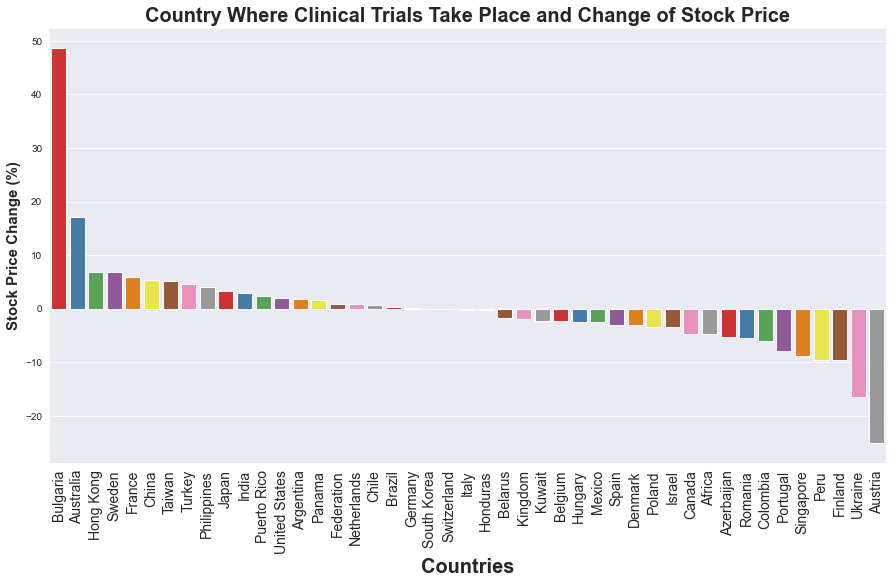

In [10]:
sns.color_palette('Set1')
sns.set_style('darkgrid')

fig, ax=plt.subplots(1, figsize=(15,8))

sns.barplot(x=q3_df.extract_country, y=q3_df.percentage,  ax=ax, palette='Set1')
ax.set_xlabel('Countries', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_ylabel('Stock Price Change (%)', fontdict={'fontsize': 15, 'weight':'bold'})
ax.set_title('Country Where Clinical Trials Take Place and Change of Stock Price', fontdict={'fontsize': 20, 'weight':'bold'})
ax.set_xticklabels(q3_df.extract_country, rotation=90, fontsize=14);